In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import random
from urllib import request
from sklearn.feature_extraction.text import CountVectorizer

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
train = pd.read_csv('train_semeval_parids-labels.csv')
val = pd.read_csv('dev_semeval_parids-labels.csv')
print(train.head())
print(val.head())

   par_id                  label
0    4341  [1, 0, 0, 1, 0, 0, 0]
1    4136  [0, 1, 0, 0, 0, 0, 0]
2   10352  [1, 0, 0, 0, 0, 1, 0]
3    8279  [0, 0, 0, 1, 0, 0, 0]
4    1164  [1, 0, 0, 1, 1, 1, 0]
   par_id                  label
0    4046  [1, 0, 0, 1, 0, 0, 0]
1    1279  [0, 1, 0, 0, 0, 0, 0]
2    8330  [0, 0, 1, 0, 0, 0, 0]
3    4063  [1, 0, 0, 1, 1, 1, 0]
4    4089  [1, 0, 0, 0, 0, 0, 0]


In [5]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [6]:

module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


In [9]:

from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('', 'dontpatronizeme_pcl.tsv')

In [10]:

# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
dpm.train_task1_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0


Investigate Class imbalance:

In [ ]:
print(len(dpm.train_task1_df[dpm.train_task1_df['label'] == 0]))
print(len(dpm.train_task1_df[dpm.train_task1_df['label'] == 1]))
#print(len(dpm.train_task1_df[dpm.train_task1_df['country'] == 'us']))

9476
993
543


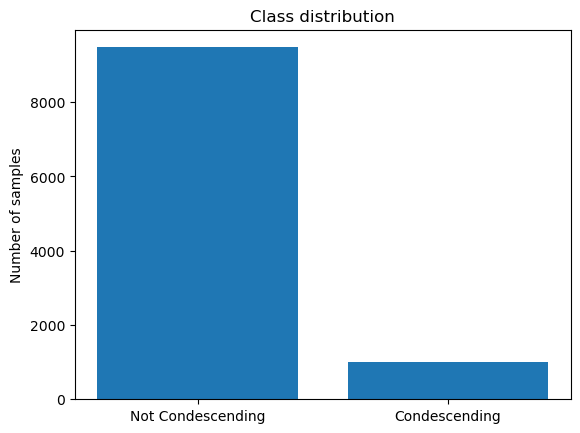

In [21]:
df = dpm.train_task1_df

label_counts = df["label"].value_counts().sort_index()

plt.bar(label_counts.index, label_counts.values)
plt.xticks([0, 1], ["Not Condescending", "Condescending"])
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.show()

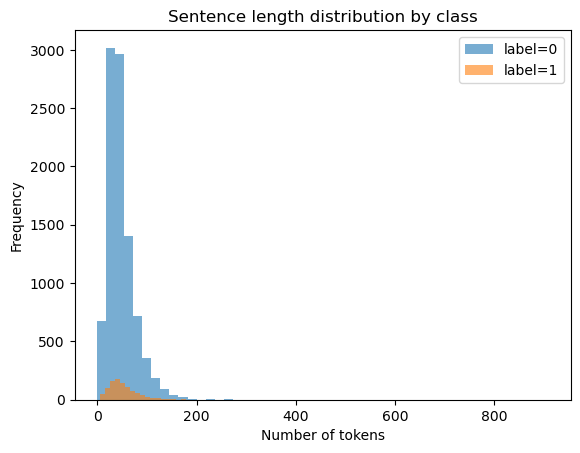

In [22]:
df["n_tokens"] = df["text"].str.split().apply(len)

plt.hist(df[df["label"] == 0]["n_tokens"], bins=50, alpha=0.6, label="label=0")
plt.hist(df[df["label"] == 1]["n_tokens"], bins=50, alpha=0.6, label="label=1")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.legend()
plt.title("Sentence length distribution by class")
plt.show()

Check vocab size:

In [17]:
df = dpm.train_task1_df
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english"  # optional but recommended
)

X = vectorizer.fit_transform(df["text"])

vocab = vectorizer.get_feature_names_out()
vocab_size = len(vocab)

print("Vocabulary size (overall):", vocab_size)

Vocabulary size (overall): 29702


Check word freq.

In [18]:
import numpy as np

word_counts = X.sum(axis=0)              # total frequency per word
word_counts = np.asarray(word_counts).flatten()

freq_df = pd.DataFrame({
    "word": vocab,
    "count": word_counts
}).sort_values("count", ascending=False)

freq_df.head(20)

,word,count
23344,said,2162
19914,people,1850
29279,women,1718
18154,need,1344
9891,families,1341
12994,immigrants,1296
28716,vulnerable,1204
20557,poor,1190
7873,disabled,1145
5195,children,1039


In [19]:
df_pos = df[df["label"] == 1]

X_pos = vectorizer.fit_transform(df_pos["text"])
vocab_pos = vectorizer.get_feature_names_out()

print("Vocabulary size (positive class):", len(vocab_pos))

word_counts_pos = X_pos.sum(axis=0)
word_counts_pos = np.asarray(word_counts_pos).flatten()

freq_pos_df = pd.DataFrame({
    "word": vocab_pos,
    "count": word_counts_pos
}).sort_values("count", ascending=False)

freq_pos_df.head(20)

Vocabulary size (positive class): 7483


,word,count
4983,people,257
4569,need,238
5139,poor,234
2548,families,212
1244,children,199
5886,said,194
3204,homeless,177
7378,women,146
3148,help,136
1983,disabled,105


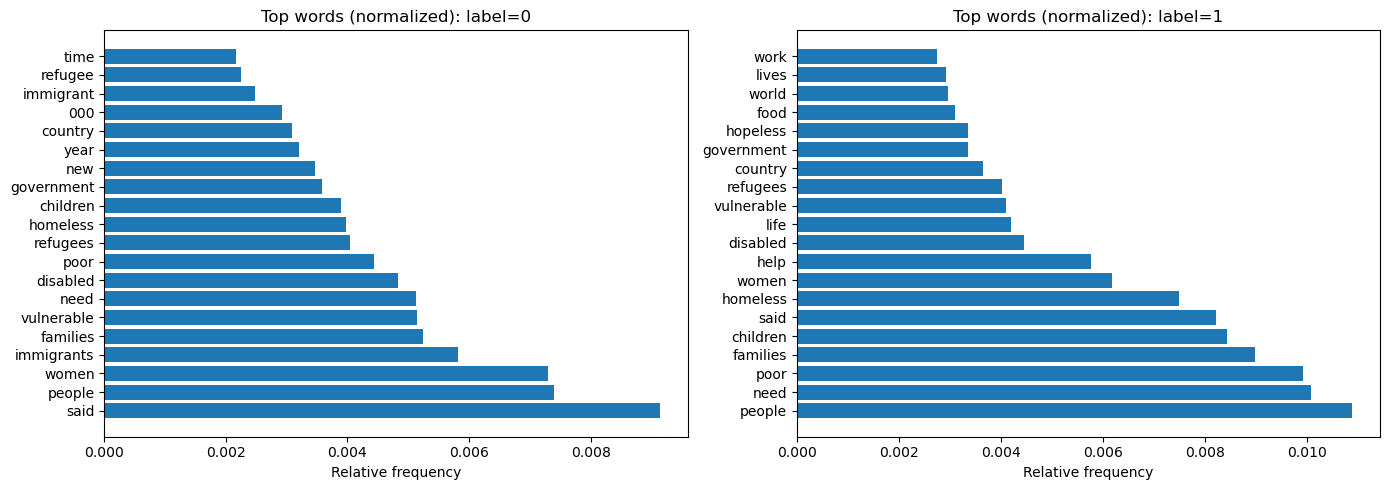

In [25]:


def top_words_normalized(df_subset, n=20):
    vec = CountVectorizer(stop_words="english")
    X = vec.fit_transform(df_subset["text"])

    words = vec.get_feature_names_out()
    counts = X.sum(axis=0).A1
    total_tokens = counts.sum()

    freqs = counts / total_tokens

    return (
        pd.DataFrame({"word": words, "freq": freqs})
        .sort_values("freq", ascending=False)
        .head(n)
    )
top_neg = top_words_normalized(df[df["label"] == 0])
top_pos = top_words_normalized(df[df["label"] == 1])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(top_neg["word"], top_neg["freq"])
axes[0].set_title("Top words (normalized): label=0")
axes[0].set_xlabel("Relative frequency")

axes[1].barh(top_pos["word"], top_pos["freq"])
axes[1].set_title("Top words (normalized): label=1")
axes[1].set_xlabel("Relative frequency")

plt.tight_layout()
plt.show()

Explore words that are distinctive for the positive class

In [20]:
# build overall frequency table
vectorizer_all = CountVectorizer(stop_words="english")
X_all = vectorizer_all.fit_transform(df["text"])

vocab_all = vectorizer_all.get_feature_names_out()
counts_all = X_all.sum(axis=0).A1

# align positive counts with overall vocab
pos_counts = pd.Series(word_counts_pos, index=vocab_pos)
all_counts = pd.Series(counts_all, index=vocab_all)

ratio_df = (
    pos_counts / all_counts
).dropna().sort_values(ascending=False)

ratio_df.head(20)

zululand      1.0
risking       1.0
roadblocks    1.0
rm100         1.0
rj            1.0
emulated      1.0
emulating     1.0
rivalries     1.0
endorsing     1.0
rotorua       1.0
ringgren      1.0
rind          1.0
rimutaka      1.0
righteous     1.0
enhances      1.0
enlarged      1.0
roadshow      1.0
employable    1.0
robber        1.0
emotes        1.0
dtype: float64

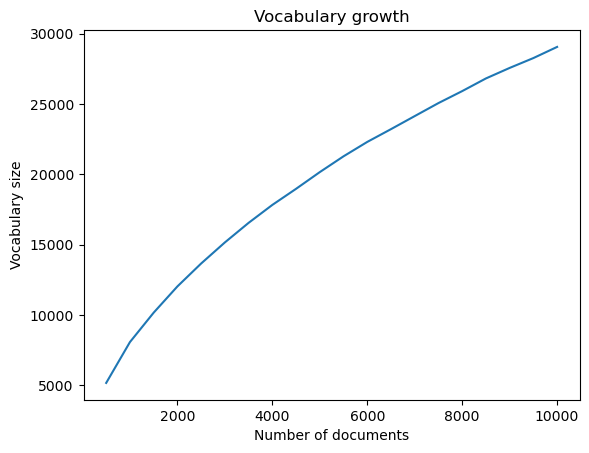

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def vocab_growth(texts, step=500):
    sizes = []
    vectorizer = CountVectorizer(stop_words="english")

    for i in range(step, len(texts), step):
        X = vectorizer.fit_transform(texts[:i])
        sizes.append(len(vectorizer.get_feature_names_out()))
    return sizes

growth = vocab_growth(df["text"].tolist())

plt.plot(range(500, 500 * len(growth) + 1, 500), growth)
plt.xlabel("Number of documents")
plt.ylabel("Vocabulary size")
plt.title("Vocabulary growth")
plt.show()

As the vocab is continuing to grow:
	•	bag-of-words will stay sparse
	•	subword models (BERT, SentencePiece) are safer

### RoBERTa build:

In [1]:


from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

c:\Users\tomjo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [12]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  print(device_name)    
  # The device name should look like the following:
  if device_name == '':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Cuda available?  True

Found GPU at: 


In [3]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

  # helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [4]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()


In [5]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
data=dpm.train_task1_df

In [6]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })
  import random
  trdf1 = pd.DataFrame(rows)

In [8]:
import random

rows = []  # will contain par_id, label and text
for idx in range(len(teids)):  
    parid = teids.par_id[idx]
    # select row from original dataset
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })

# Create DataFrame AFTER the loop
tedf1 = pd.DataFrame(rows)

# Shuffle the DataFrame using pandas sample method
tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

print(tedf1.head())

  par_id  community                                               text  label
0   9783  immigrant  I am in no way , however , trying to insinuate...      0
1   9424   hopeless  Chris Selley : Maybe liquor retail in Ontario ...      0
2   9858    in-need  In total , FAO 's latest food insecurity asses...      0
3   9160      women  But a jury of seven men and five women today f...      0
4   9236   hopeless  I say so is because one day they seem to be do...      0


In [9]:
print(len(trdf1[trdf1['label'] == 0]))
print(len(trdf1[trdf1['label'] == 1]))

7581
794


In [76]:
import os
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
# Oversample pcldf 10 times
pcldf_oversampled = pd.concat([pcldf] * 10, ignore_index=True)

training_set1 = pd.concat(
    [pcldf_oversampled, trdf1[trdf1['label'] == 0][:npos*10]],
    ignore_index=True
)

#training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
print(training_set1['label'].value_counts())
print(training_set1.head())
# Try upsampling instead of downsampling:

#training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide all GPUs from PyTorch

print("torch.cuda.is_available():", torch.cuda.is_available())
print("simpletransformers will use CUDA:", cuda_available)
task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
train_df = training_set1[['text', 'label']].rename(columns={'label': 'labels'})
print(train_df.head())
print(train_df.dtypes)

task1_model.train_model(train_df)
#task1_model.train_model(training_set1[['text', 'label']])
# run predictions
train_preds_task1, _ = task1_model.predict(trdf1.text.tolist())
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

label
1    7940
0    7581
Name: count, dtype: int64
  par_id      community                                               text  \
0   4341  poor-families  The scheme saw an estimated 150,000 children f...   
1   4136       homeless  Durban 's homeless communities reconciliation ...   
2  10352  poor-families  The next immediate problem that cropped up was...   
3   8279     vulnerable  Far more important than the implications for t...   
4   1164  poor-families  To strengthen child-sensitive social protectio...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
torch.cuda.is_available(): True
simpletransformers will use CUDA: True


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

                                                text  labels
0  The scheme saw an estimated 150,000 children f...       1
1  Durban 's homeless communities reconciliation ...       1
2  The next immediate problem that cropped up was...       1
3  Far more important than the implications for t...       1
4  To strengthen child-sensitive social protectio...       1
text      object
labels     int64
dtype: object


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 1:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1 of 1: 100%|██████████| 1/1 [05:05<00:00, 305.54s/it]
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Conver

In [77]:
labels2file([[k] for k in preds_task1], 'task1_take2.txt')

In [78]:
from sklearn.metrics import classification_report

In [79]:
train_labels = trdf1['label'].tolist()   
train_preds = train_preds_task1.tolist()

print(classification_report(train_labels, train_preds, digits=4))  

              precision    recall  f1-score   support

           0     0.9989    0.9678    0.9831      7581
           1     0.7631    0.9899    0.8618       794

    accuracy                         0.9699      8375
   macro avg     0.8810    0.9789    0.9225      8375
weighted avg     0.9766    0.9699    0.9716      8375



In [80]:
test_labels = tedf1['label'].tolist()   
preds = preds_task1.tolist()

print(classification_report(test_labels, preds, digits=4))  

              precision    recall  f1-score   support

           0     0.9566    0.9430    0.9498      1895
           1     0.5221    0.5930    0.5553       199

    accuracy                         0.9097      2094
   macro avg     0.7394    0.7680    0.7525      2094
weighted avg     0.9153    0.9097    0.9123      2094



In [26]:
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
labels2file(dpm.train_task1_df.label.apply(lambda x:[x]).tolist(), os.path.join('input/ref/', 'task1.txt'))

In [68]:
from sklearn.metrics import f1_score, recall_score, precision_score
Recalls = []
Precisions = [] 
F1s = []

for i in [1,2,5]:
    # downsample negative instances
    pcldf = trdf1[trdf1.label==1]
    npos = len(pcldf)
    # Oversample pcldf 10 times
    pcldf_oversampled = pd.concat([pcldf] * i, ignore_index=True)

    training_set1 = pd.concat(
        [pcldf_oversampled, trdf1[trdf1['label'] == 0][:npos*2*i]],
        ignore_index=True
    )

    #training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
    print(training_set1['label'].value_counts())
    print(training_set1.head())
    # Try upsampling instead of downsampling:

    #training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

    os.environ["CUDA_VISIBLE_DEVICES"] = ""  # hide all GPUs from PyTorch

    print("torch.cuda.is_available():", torch.cuda.is_available())
    print("simpletransformers will use CUDA:", cuda_available)
    task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                        no_save=True, 
                                        no_cache=True, 
                                        overwrite_output_dir=True)
    task1_model = ClassificationModel("roberta", 
                                    'roberta-base', 
                                    args = task1_model_args, 
                                    num_labels=2, 
                                    use_cuda=cuda_available)
    # train model
    train_df = training_set1[['text', 'label']].rename(columns={'label': 'labels'})
    print(train_df.head())
    print(train_df.dtypes)

    task1_model.train_model(train_df)
    #task1_model.train_model(training_set1[['text', 'label']])
    # run predictions
    train_preds_task1, _ = task1_model.predict(trdf1.text.tolist())
    preds_task1, _ = task1_model.predict(tedf1.text.tolist())
    test_labels = tedf1['label'].tolist()   
    preds = preds_task1.tolist()

    F1s.append(f1_score(test_labels, preds, average='binary', zero_division=0))  
    Recalls.append(recall_score(test_labels, preds, average='binary', zero_division=0))
    Precisions.append(precision_score(test_labels, preds, average='binary', zero_division=0))

label
0    1588
1     794
Name: count, dtype: int64
  par_id      community                                               text  \
0   4341  poor-families  The scheme saw an estimated 150,000 children f...   
1   4136       homeless  Durban 's homeless communities reconciliation ...   
2  10352  poor-families  The next immediate problem that cropped up was...   
3   8279     vulnerable  Far more important than the implications for t...   
4   1164  poor-families  To strengthen child-sensitive social protectio...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
torch.cuda.is_available(): True
simpletransformers will use CUDA: True


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

                                                text  labels
0  The scheme saw an estimated 150,000 children f...       1
1  Durban 's homeless communities reconciliation ...       1
2  The next immediate problem that cropped up was...       1
3  Far more important than the implications for t...       1
4  To strengthen child-sensitive social protectio...       1
text      object
labels     int64
dtype: object


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 1:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1 of 1: 100%|██████████| 1/1 [00:34<00:00, 34.70s/it]
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Convert

label
0    3176
1    1588
Name: count, dtype: int64
  par_id      community                                               text  \
0   4341  poor-families  The scheme saw an estimated 150,000 children f...   
1   4136       homeless  Durban 's homeless communities reconciliation ...   
2  10352  poor-families  The next immediate problem that cropped up was...   
3   8279     vulnerable  Far more important than the implications for t...   
4   1164  poor-families  To strengthen child-sensitive social protectio...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
torch.cuda.is_available(): True
simpletransformers will use CUDA: True


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

                                                text  labels
0  The scheme saw an estimated 150,000 children f...       1
1  Durban 's homeless communities reconciliation ...       1
2  The next immediate problem that cropped up was...       1
3  Far more important than the implications for t...       1
4  To strengthen child-sensitive social protectio...       1
text      object
labels     int64
dtype: object


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 1:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1 of 1: 100%|██████████| 1/1 [01:28<00:00, 88.62s/it]
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/1047 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roami

label
0    7581
1    3970
Name: count, dtype: int64
  par_id      community                                               text  \
0   4341  poor-families  The scheme saw an estimated 150,000 children f...   
1   4136       homeless  Durban 's homeless communities reconciliation ...   
2  10352  poor-families  The next immediate problem that cropped up was...   
3   8279     vulnerable  Far more important than the implications for t...   
4   1164  poor-families  To strengthen child-sensitive social protectio...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  
torch.cuda.is_available(): True
simpletransformers will use CUDA: True


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

                                                text  labels
0  The scheme saw an estimated 150,000 children f...       1
1  Durban 's homeless communities reconciliation ...       1
2  The next immediate problem that cropped up was...       1
3  Far more important than the implications for t...       1
4  To strengthen child-sensitive social protectio...       1
text      object
labels     int64
dtype: object


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:884: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 of 1:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1 of 1: 100%|██████████| 1/1 [03:57<00:00, 237.71s/it]
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/1047 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roam

[0.7437185929648241, 0.7487437185929648, 0.6683417085427136]
[0.2954091816367265, 0.3962765957446808, 0.4618055555555556]
[0.4228571428571429, 0.5182608695652174, 0.5462012320328542]


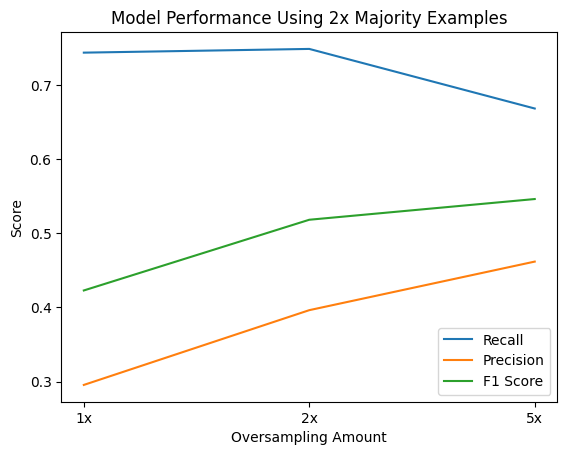

In [83]:
print(Recalls)
print(Precisions)
print(F1s)

plt.figure()
plt.plot([1,2,3], Recalls, label='Recall')
plt.plot([1,2,3], Precisions, label='Precision')
plt.plot([1,2,3], F1s, label='F1 Score')
plt.xlabel('Oversampling Amount')
plt.xticks([1, 2, 3], ['1x', '2x', '5x'])
plt.ylabel('Score')
plt.title('Model Performance Using 2x Majority Examples')
plt.legend()
plt.show()

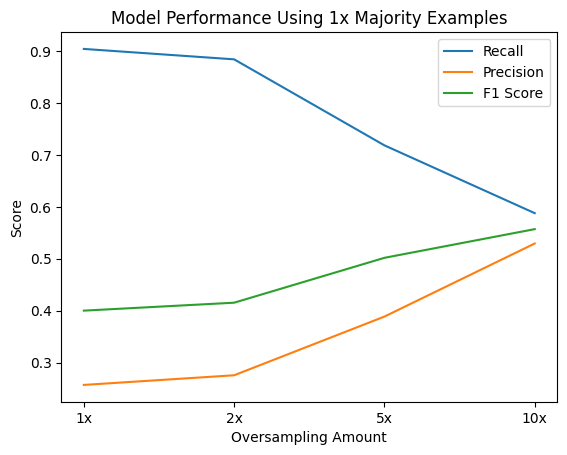

In [75]:
Recalls_1 = [0.9045, 0.88442,  0.7186, 0.5879]  
Precisions_1 = [0.2568, 0.2754, 0.38854, 0.5294]
F1s_1 = [0.4, 0.4153, 0.5018, 0.5571]

plt.figure()
plt.plot([1,2,3,4], Recalls_1, label='Recall')
plt.plot([1,2,3,4], Precisions_1, label='Precision')
plt.plot([1,2,3,4], F1s_1, label='F1 Score')
plt.xlabel('Oversampling Amount')
plt.xticks([1, 2, 3, 4], ['1x', '2x', '5x', '10x'])
plt.ylabel('Score')
plt.title('Model Performance Using 1x Majority Examples')
plt.legend()
plt.show()

### Analyse errors:

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ============================================
# 1. GET PREDICTIONS AND TRUE LABELS
# ============================================

# Your existing code to create tedf1
rows = []
for idx in range(len(teids)):  
    parid = teids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })

tedf1 = pd.DataFrame(rows)
tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

# Get predictions (assuming you have a trained model)
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

# Add predictions to dataframe
tedf1['predicted_label'] = preds_task1
tedf1['correct'] = tedf1['label'] == tedf1['predicted_label']

print(f"Total samples: {len(tedf1)}")
print(f"Correct predictions: {tedf1['correct'].sum()}")
print(f"Incorrect predictions: {(~tedf1['correct']).sum()}")

# ============================================
# 2. IDENTIFY FALSE POSITIVES AND FALSE NEGATIVES
# ============================================

# False Positives: Predicted 1 (PCL), Actually 0 (Non-PCL)
false_positives = tedf1[(tedf1['label'] == 0) & (tedf1['predicted_label'] == 1)]

# False Negatives: Predicted 0 (Non-PCL), Actually 1 (PCL)
false_negatives = tedf1[(tedf1['label'] == 1) & (tedf1['predicted_label'] == 0)]

# True Positives: Predicted 1, Actually 1
true_positives = tedf1[(tedf1['label'] == 1) & (tedf1['predicted_label'] == 1)]

# True Negatives: Predicted 0, Actually 0
true_negatives = tedf1[(tedf1['label'] == 0) & (tedf1['predicted_label'] == 0)]

print("\n" + "="*70)
print("PREDICTION BREAKDOWN")
print("="*70)
print(f"False Positives (FP): {len(false_positives)}")
print(f"False Negatives (FN): {len(false_negatives)}")
print(f"True Positives  (TP): {len(true_positives)}")
print(f"True Negatives  (TN): {len(true_negatives)}")

# ============================================
# 3. DISPLAY FALSE POSITIVE EXAMPLES
# ============================================

print("\n" + "="*70)
print("FALSE POSITIVE EXAMPLES")
print("(Model predicted PCL, but actually Non-PCL)")
print("="*70)

for idx, row in false_positives.head(5).iterrows():
    print(f"\n{'─'*70}")
    print(f"Par ID: {row['par_id']}")
    print(f"Community: {row['community']}")
    print(f"True Label: {row['label']} (Non-PCL)")
    print(f"Predicted: {row['predicted_label']} (PCL)")
    print(f"\nText:")
    print(f"{row['text'][:300]}...")  # Show first 300 characters
    print(f"{'─'*70}")

# ============================================
# 4. DISPLAY FALSE NEGATIVE EXAMPLES
# ============================================

print("\n" + "="*70)
print("FALSE NEGATIVE EXAMPLES")
print("(Model predicted Non-PCL, but actually PCL)")
print("="*70)

for idx, row in false_negatives.head(5).iterrows():
    print(f"\n{'─'*70}")
    print(f"Par ID: {row['par_id']}")
    print(f"Community: {row['community']}")
    print(f"True Label: {row['label']} (PCL)")
    print(f"Predicted: {row['predicted_label']} (Non-PCL)")
    print(f"\nText:")
    print(f"{row['text'][:1000]}...")
    print(f"{'─'*70}")

# ============================================
# 5. SAVE ERRORS TO CSV FILES
# ============================================

# Save false positives
false_positives.to_csv('false_positives.csv', index=False)
print(f"\n✓ Saved {len(false_positives)} false positives to 'false_positives.csv'")

# Save false negatives
false_negatives.to_csv('false_negatives.csv', index=False)
print(f"✓ Saved {len(false_negatives)} false negatives to 'false_negatives.csv'")

# Save all predictions
tedf1.to_csv('all_predictions.csv', index=False)
print(f"✓ Saved all {len(tedf1)} predictions to 'all_predictions.csv'")

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/262 [00:00<?, ?it/s]C:\Users\tomjo\AppData\Roaming\Python\Python39\site-packages\simpletransformers\classification\classification_model.py:2187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 262/262 [00:07<00:00, 36.09it/s]

Total samples: 2094
Correct predictions: 1905
Incorrect predictions: 189

PREDICTION BREAKDOWN
False Positives (FP): 108
False Negatives (FN): 81
True Positives  (TP): 118
True Negatives  (TN): 1787

FALSE POSITIVE EXAMPLES
(Model predicted PCL, but actually Non-PCL)

──────────────────────────────────────────────────────────────────────
Par ID: 9592
Community: homeless
True Label: 0 (Non-PCL)
Predicted: 1 (PCL)

Text:
PETA commends Born Free Entertainment for setting a positive example for movie fans to follow by showing that homeless dogs make wonderful additions to families ....
──────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────
Par ID: 9800
Community: refugee
True Label: 0 (Non-PCL)
Predicted: 1 (PCL)

Text:
"The last time Makenga saw his parents was 15 years ago , and since then he has never seen them because they fled DRC following the outbreak of the civil war . "" We want all Congolese r

In [82]:
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

def preprocess_text(text):
    """
    Clean and tokenize text
    
    Parameters:
    -----------
    text : str
        Input text
        
    Returns:
    --------
    list : List of cleaned tokens
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Split into words
    words = text.split()
    
    # Remove stop words and short words
    words = [w for w in words if w not in ENGLISH_STOP_WORDS and len(w) > 2]
    
    return words


def analyze_word_frequency(texts, top_n=5, dataset_name="Dataset"):
    """
    Analyze word frequency in a collection of texts
    
    Parameters:
    -----------
    texts : list
        List of text strings
    top_n : int
        Number of top words to return
    dataset_name : str
        Name for display
        
    Returns:
    --------
    dict : Dictionary with word frequencies
    """
    
    # Combine all texts and preprocess
    all_words = []
    for text in texts:
        words = preprocess_text(str(text))
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get top N words
    top_words = word_counts.most_common(top_n)
    
    # Calculate total words and unique words
    total_words = len(all_words)
    unique_words = len(word_counts)
    
    # Print results
    print(f"\n{'='*70}")
    print(f"{dataset_name.upper()} - WORD FREQUENCY ANALYSIS")
    print(f"{'='*70}")
    print(f"Total documents: {len(texts)}")
    print(f"Total words: {total_words:,}")
    print(f"Unique words: {unique_words:,}")
    print(f"\nTop {top_n} Most Frequent Words:")
    print(f"{'─'*70}")
    print(f"{'Rank':<6} {'Word':<20} {'Count':<10} {'Percentage':<12}")
    print(f"{'─'*70}")
    
    for rank, (word, count) in enumerate(top_words, 1):
        percentage = (count / total_words) * 100
        print(f"{rank:<6} {word:<20} {count:<10,} {percentage:<12.2f}%")
    
    return {
        'top_words': top_words,
        'word_counts': word_counts,
        'total_words': total_words,
        'unique_words': unique_words,
        'dataset_name': dataset_name
    }
print(analyze_word_frequency(trdf1.text.tolist()))
print(analyze_word_frequency(false_positives.text.tolist()))
print(analyze_word_frequency(false_negatives.text.tolist()))



DATASET - WORD FREQUENCY ANALYSIS
Total documents: 8375
Total words: 185,423
Unique words: 25,519

Top 5 Most Frequent Words:
──────────────────────────────────────────────────────────────────────
Rank   Word                 Count      Percentage  
──────────────────────────────────────────────────────────────────────
1      said                 1,752      0.94        %
2      people               1,506      0.81        %
3      women                1,314      0.71        %
4      need                 1,071      0.58        %
5      families             1,062      0.57        %
{'top_words': [('said', 1752), ('people', 1506), ('women', 1314), ('need', 1071), ('families', 1062)], 'word_counts': Counter({'said': 1752, 'people': 1506, 'women': 1314, 'need': 1071, 'families': 1062, 'immigrants': 1036, 'vulnerable': 973, 'poor': 957, 'disabled': 919, 'homeless': 826, 'children': 805, 'refugees': 786, 'government': 675, 'new': 657, 'country': 598, 'year': 584, 'immigrant': 448, 'refugee': 4

The idea: use back translation of positive cases to improve the size of the training corpus and help reduce the class imbalance and overfitting of BERT - large, potentially making this model viable.